In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift
from scipy.ndimage import gaussian_filter

# Constants
E_b = 1000.0 # Pa
E_c = 100.0 # Pa
E_s = 1.0 # Pa
h_b = 1e-2 # m
h_c = 1e-5 # m
gamma = 1.0 # N/m


K_c = (E_c * (h_c)**3) /9
hb_hc_ratio = h_b / h_c 
Eb_Ec_ratio = E_b / E_c
Es_Ec_ratio = E_s / E_c
# non_linear_prefactor = 9 * Eb_Ec_ratio * (hb_hc_ratio)**(1/3) 
# f_el_prefactor = 3 * Es_Ec_ratio * (hb_hc_ratio)**(1/3)

non_linear_prefactor = 1.0
f_el_prefactor = 1.0

gamma_c = (3 * K_c * E_s**2 )**(1/3)
lambda_c = 2 * np.pi * (K_c / E_s)**(1/3)

print(lambda_c)
print(gamma / gamma_c)
print(non_linear_prefactor)
print(f_el_prefactor)

0.00014020570920327251
31072.32505953857
1.0
1.0


![title](equations.jpg)

![title](tgdl.jpg)

![title](first_order_semi_implicit.jpg)

![title](image.png)

# Testing Basics


In [3]:
def initialize_grid(total_time=5.0, Nx=128, Ny=128, Lx=128.0, Ly=128.0, dt=0.01):

    # Parameters for the domain
    dx, dy = Lx / Nx, Ly / Ny  # Grid spacing
    steps = int(total_time / dt)

    # Create spatial grid centered at (0,0)
    x = np.linspace(-Lx / 2, Lx / 2, Nx, endpoint=False)
    y = np.linspace(-Ly / 2, Ly / 2, Ny, endpoint=False)
    X, Y = np.meshgrid(x, y)

    # Wavenumber grids in Fourier space (centered)
    kx_unshifted = 2 * np.pi * fftfreq(Nx, d=dx)
    ky_unshifted = 2 * np.pi * fftfreq(Ny, d=dy)
    kx = fftshift(kx_unshifted)
    ky = fftshift(ky_unshifted)
    KX, KY = np.meshgrid(kx, ky)  # Shift to center k-space around (0,0)

    K_squared = KX**2 + KY**2
    K = np.sqrt(K_squared)
    K_fourth = K_squared**2

    # Handling division by zero at k=0
    K[K == 0] = 1e-20
    center_idx = Nx // 2

    return Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx

def fft_transform(field):
    return fftshift(fft2(field))  # Shift zero-frequency component to the center

def ifft_transform(field_tilde):
    return np.real(ifft2(ifftshift(field_tilde)))  # Shift back for inverse transform

def plot_3d(x, y, z, title):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the surface
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('w')
    ax.view_init(elev=45, azim=-135)
    ax.plot_surface(x, y, z, cmap='viridis', rstride=1, cstride=1, antialiased=True)

    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(z)
    plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
    plt.show()

def plot_2d(x, y, z, title):
    
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(x, y, z, cmap='viridis')
    plt.colorbar(label='w')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to equal
    plt.show()



def generate_smooth_random_2d_array(size=(100, 100), sigma=1.0):
    # Generate random noise
    noise = np.random.normal(size=size)
    
    # Apply Gaussian filter to smooth the noise
    smooth_array = gaussian_filter(noise, sigma=sigma)
    
    return smooth_array

# plt.imshow(smooth_array, cmap='viridis')
# plt.colorbar()
# plt.title('Smooth Random 2D Array (Gaussian Filter)')
# plt.show()

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid()

# w = np.exp((-X*X - Y*Y)/4086) * 0.1

w = np.sin(2 * np.pi * X / 32)

w_tilde = fft_transform(w)

# plot_2d(X, Y, w, 'Initial condition')
# plot_2d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

# plot_3d(X, Y, w, 'Initial condition')
# plot_3d(KX, KY, np.abs(w_tilde), 'Initial condition in Fourier space')

# Linear Part

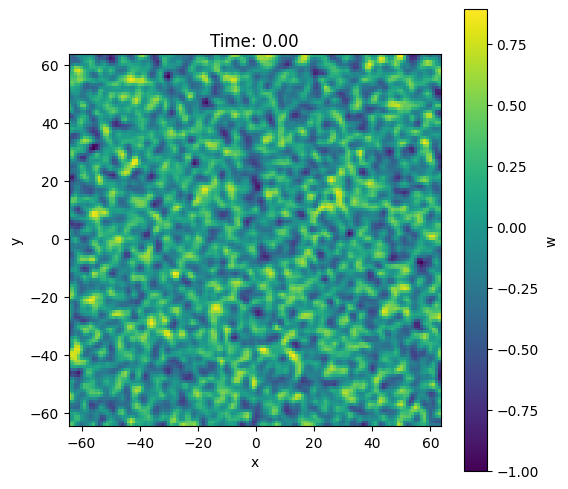

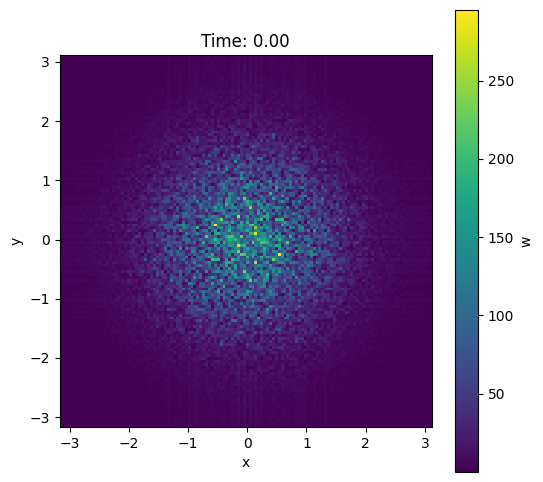

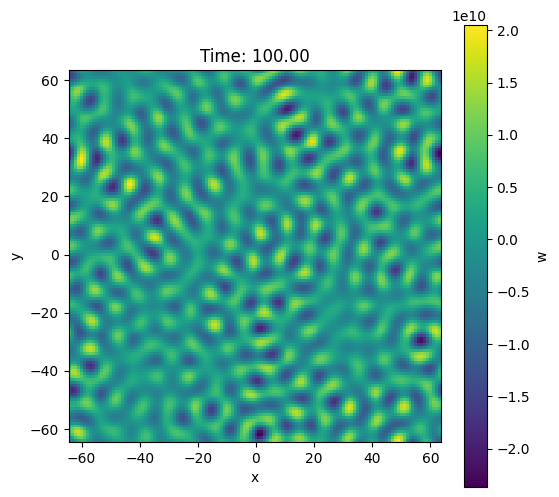

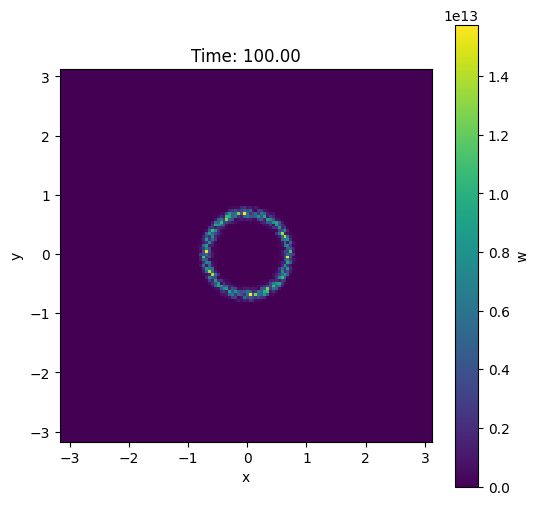

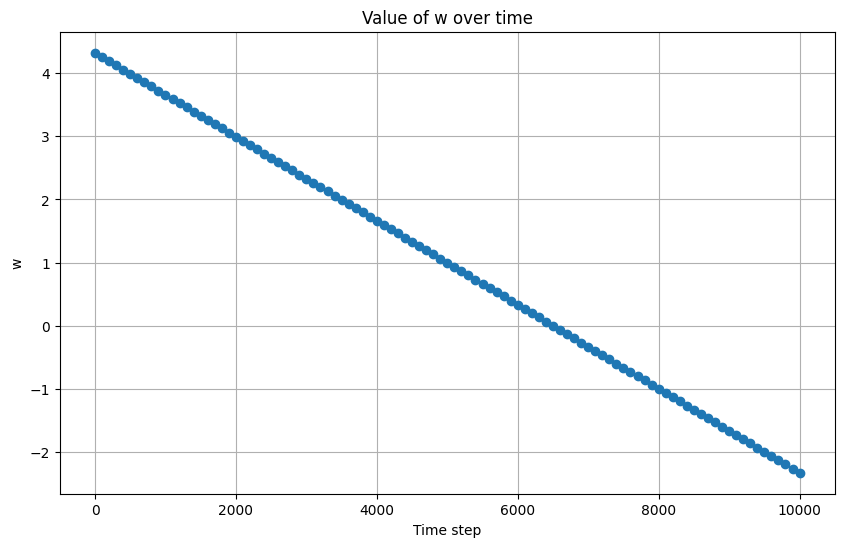

fourier component: (0.0, 1.030835089459151)
1.1291633506646053 1.0626209816602556
Theoretical slope: -0.0006654236900434962
The slope of the graph of 10 10 is: -0.0006652023938647959


In [4]:
def linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde):
    w_tilde_new = w_tilde / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = u1_tilde
    u2_tilde_new = u2_tilde
    return w_tilde_new, u1_tilde_new, u2_tilde_new

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(101)

w = generate_smooth_random_2d_array(size=(Nx, Ny))  # Initial condition
# w = np.exp((-X*X - Y*Y))
#w = np.cos(2 * np.pi * X / 32) + np.cos(2 * np.pi * Y / 32)
u1 = np.zeros((Nx, Ny))  # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))  # Initial displacement in y direction

w_values = []  # List to store the value of w at center (0,0) over time

# Fourier transform of w
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)


for step in range(steps):
    
    w_tilde_new, u1_tilde_new, u2_tilde_new = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    
    # Inverse Fourier transform to get updated w in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)

    # Update Fourier components for the next step
    w_tilde, u1_tilde, u2_tilde = w_tilde_new, u1_tilde_new, u2_tilde_new

    # Store the value of w at (0,0) for analysis
    if step % 100 == 0:
        x_idx = 21
        y_idx = 0
        storing_idx = (center_idx + x_idx, center_idx + y_idx)
        epsilon = 1e-10  # A small value to avoid log(0)
        w_values.append(math.log(np.abs(w_tilde_new[storing_idx])))

    # Visualization every 1000 steps
    if step % 10000 == 0:
        
        # plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        # plot_3d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        # plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        # print(f'Max value of w: {np.max(w)}')
        #plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')

        # plt.figure(figsize=(6, 4))
        # plt.plot(kx, w_tilde[center_idx, :], label='w_tilde ')
        # plt.xlabel('x')
        # plt.ylabel('w_tilde ')
        # plt.title('w_tilde  along x axis')
        # plt.legend()
        # plt.show()
        # # Find the first non-zero value in w_tilde 
        # non_zero_indices = np.nonzero(w_tildeb)
        # first_non_zero_index = non_zero_indices[1][0]  # Get the first non-zero index in the x-direction
        # kx_value = kx[first_non_zero_index]
        # print(f'The kx value of the first non-zero w_tildeb is: {kx_value}')
        # print(f'Max value of w_tildeb: {np.max(w_tildeb)}')


# kx_values = kx
# kx_squared = kx_values**2
# kx_fourth = kx_values**4

# plt.figure(figsize=(6, 4))
# plt.plot(kx_values, -kx_fourth + gamma * kx_squared, label=r'$-k_x^4 + \gamma k_x^2$')
# plt.xlabel(r'$k_x$')
# plt.ylabel(r'$-k_x^4 + \gamma k_x^2$')
# plt.title(r'Plot of $-k_x^4 + \gamma k_x^2$')
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.xlim(-1, 1)
# # Mark the points where the curve touches the x-axis
# zero_crossings = np.where(np.diff(np.sign(-kx_fourth + gamma * kx_squared)))[0]
# for idx in zero_crossings:
#     plt.plot(kx_values[idx], 0, 'ro')  # 'ro' for red circles
# plt.legend()
# plt.show()
# print("kx values where the curve crosses the x-axis:")
# for idx in zero_crossings:
#     print(kx_values[idx])

# Fit a linear model to the data
plt.figure(figsize=(10, 6))
plt.plot(range(0, steps, 100), w_values, marker='o')
plt.title('Value of w over time')
plt.xlabel('Time step')
plt.ylabel('w')
plt.grid(True)
plt.show()

coefficients = np.polyfit(range(0, steps, 100), w_values, 1)
print(f'fourier component: {KX[center_idx + x_idx, center_idx + y_idx], KY[center_idx + x_idx, center_idx + y_idx]}')
print(K_fourth[center_idx + x_idx, center_idx + y_idx], K_squared[center_idx + x_idx, center_idx + y_idx])
print(f'Theoretical slope: {(gamma*K_squared[center_idx + x_idx, center_idx + y_idx] - K_fourth[center_idx + x_idx, center_idx + y_idx])*dt}')
slope = coefficients[0]

print(f"The slope of the graph of 10 10 is: {slope}")

# f_el part

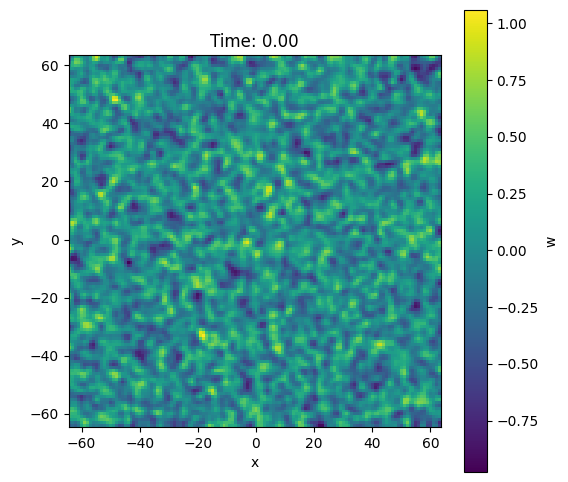

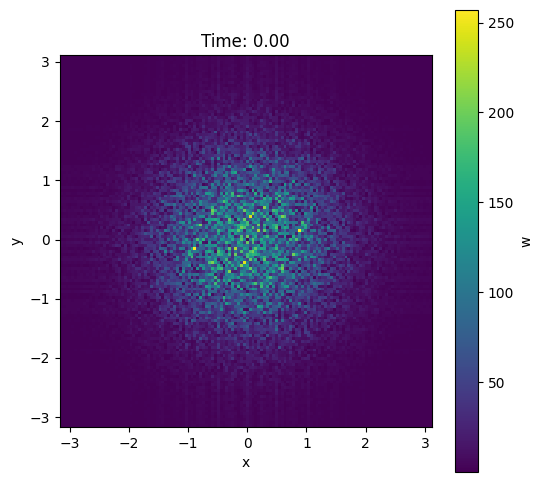

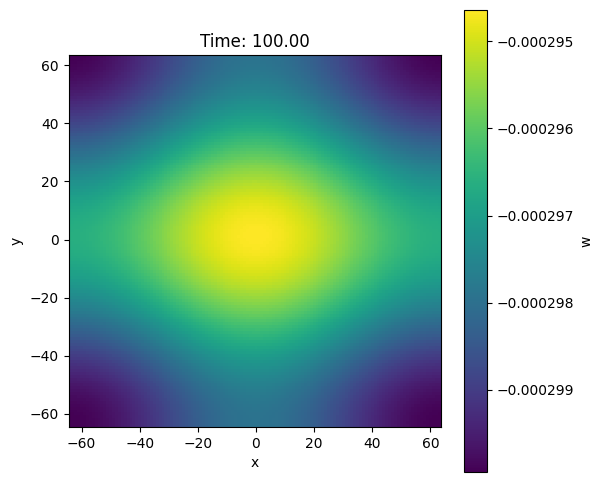

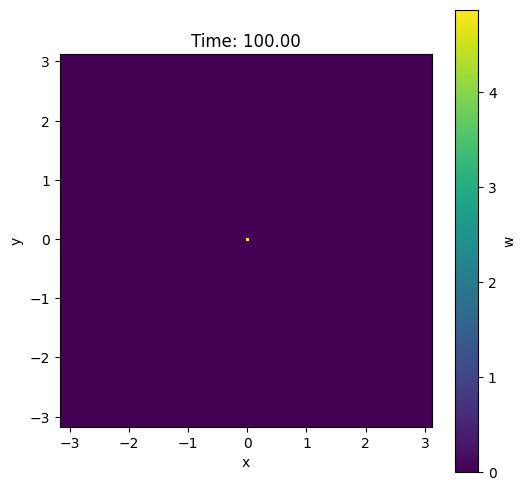

In [5]:
def compute_f_el(u1_tilde, u2_tilde, w_tilde):

    M11 = (2 * K_squared - KY**2) / K
    M12 = (KX * KY) / K
    M22 = (2 * K_squared - KX**2) / K
    M33 = 2 * K
    
    f_el_u1 = f_el_prefactor * (M11 * u1_tilde + M12 * u2_tilde)
    f_el_u2 = f_el_prefactor * (M12 * u1_tilde + M22 * u2_tilde)
    f_el_w = f_el_prefactor * M33 * w_tilde
    
    return f_el_u1, f_el_u2, f_el_w

def f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde):

    f_el_u1, f_el_u2, f_el_w = compute_f_el(u1_tilde, u2_tilde, w_tilde)
    w_tilde_new = - dt * f_el_w / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = - dt* f_el_u1 
    u2_tilde_new = - dt* f_el_u2
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(101)

# Initial conditions

# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
w = generate_smooth_random_2d_array(size=(Nx, Ny))  # Initial perturbation for w
np.save('w.npy', w)
u1 = generate_smooth_random_2d_array(size=(Nx, Ny))             # Initial displacement in x direction
u2 = generate_smooth_random_2d_array(size=(Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

for step in range(steps):

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el 
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el

    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 10000 == 0:
        # w_values.append(w[10, 10])
        
        # plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        # plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        # plot_3d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        # plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        # plot_3d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        # plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        plot_2d(KX, KY, np.abs(w_tilde), f'Time: {step * dt:.2f}')
        
# plt.figure(figsize=(10, 6))
# #plt.plot(range(0, steps, 100), w_values, marker='o')
# plt.title('Value of w at (0,0) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# #plt.show()

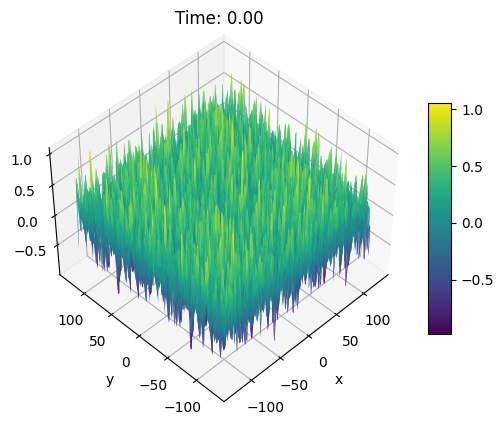

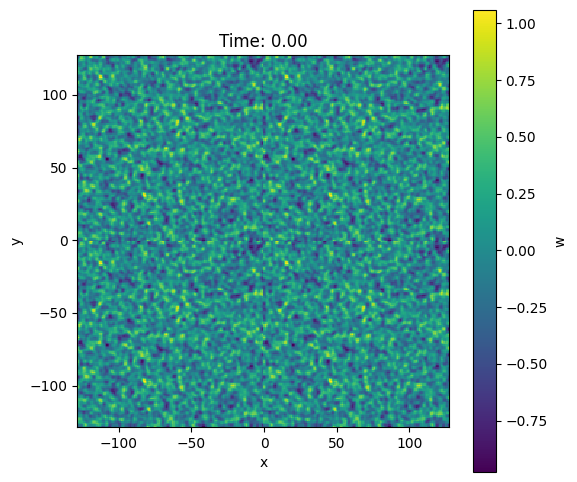

Max value of w: 1.0583494079943536


In [6]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(1, 256, 256, 256.0, 256.0)

# Initial conditions

# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
# Load the saved grid
w_small = np.load('w.npy')

# Repeat the grid to make a bigger grid of size 2*Nx x 2*Ny
w = np.tile(w_small, (2, 2))
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

for step in range(steps):

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el 
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el

    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 1000 == 0:
        # w_values.append(w[10, 10])
        
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        print(f'Max value of w: {np.max(w)}')
        
# plt.figure(figsize=(10, 6))
# #plt.plot(range(0, steps, 100), w_values, marker='o')
# plt.title('Value of w at (0,0) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# #plt.show()

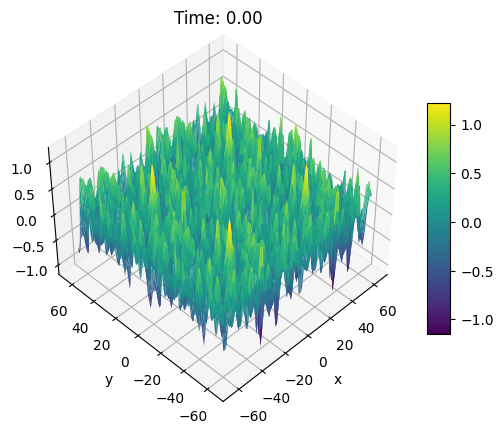

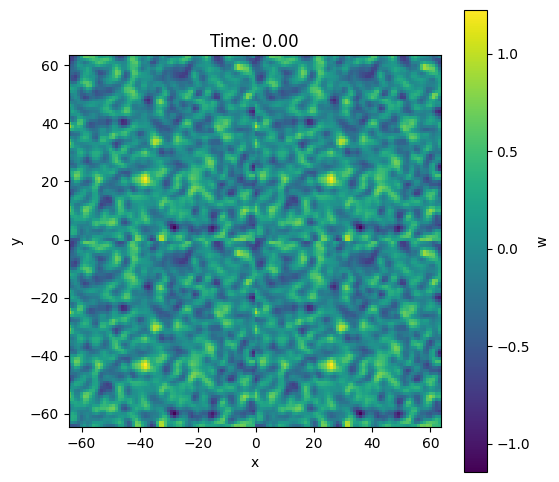

Max value of w: 1.2254726025138631


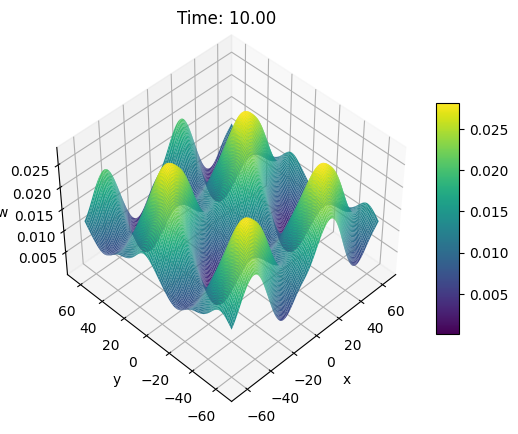

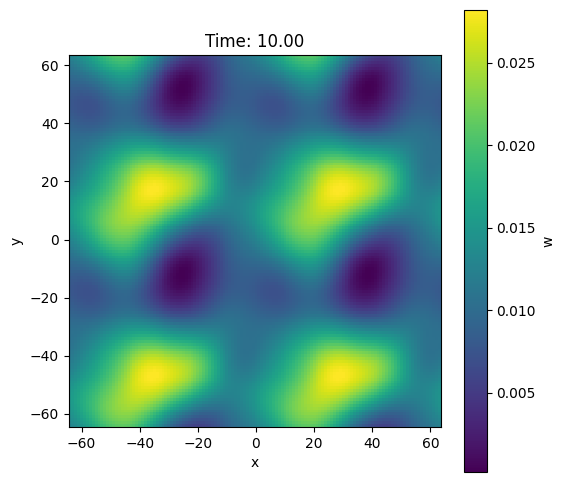

Max value of w: 0.028201063418482906


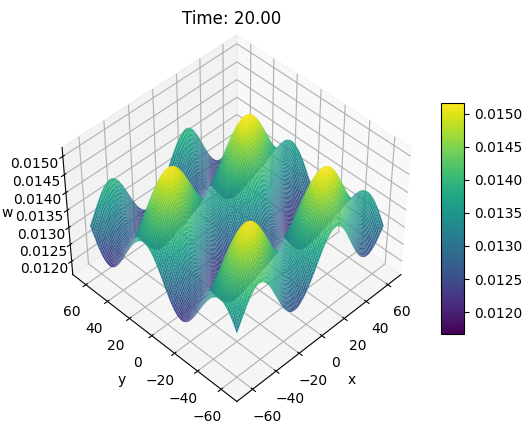

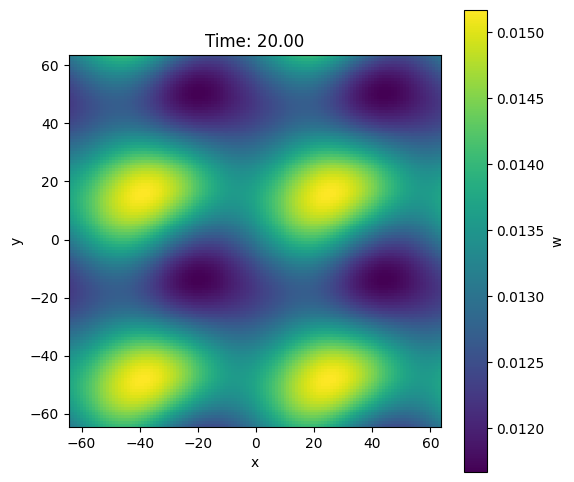

Max value of w: 0.015167859069833122


KeyboardInterrupt: 

In [7]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=100, 
                                                                                                Nx = 128, Ny = 128, Lx = 128, Ly = 128)

# Initial conditions

# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
w = generate_smooth_random_2d_array(size=(int(Nx/2), int(Ny/2)))  # Initial perturbation for w
# w = np.random.uniform(0, 1, (int(Nx/4), int(Ny/4))) * 0.1
w = np.tile(w, (Nx // w.shape[0], Ny // w.shape[1]))
# w = np.ones((Nx, Ny))
u1 = np.zeros((Nx, Ny))             # Initial displacement in x direction
u2 = np.zeros((Nx, Ny))             # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

for step in range(steps):

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el 
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el

    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 1000 == 0:
        # w_values.append(w[10, 10])
        
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
        print(f'Max value of w: {np.max(w)}')
        
# plt.figure(figsize=(10, 6))
# #plt.plot(range(0, steps, 100), w_values, marker='o')
# plt.title('Value of w at (0,0) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# #plt.show()

# Non Linear Term

In [ ]:
# def compute_nonlinear_term_for_w(w, u1, u2):

#     # Compute derivatives of w and u1, u2
#     dw_dx = derivative_x(w)
#     dw_dy = derivative_y(w)
#     du1_dy = derivative_y(u1)
#     du2_dx = derivative_x(u2)

#     # Compute the terms within the bracket
#     term_1 = dw_dy * (du1_dy + du2_dx + dw_dx * dw_dy)
#     term_2 = dw_dx * (du1_dy + du2_dx + dw_dx * dw_dy)

#     # Compute the derivative with respect to x_beta (x and y directions)
#     d_term_1_dx = derivative_x(term_1)
#     d_term_2_dy = derivative_y(term_2)

#     # Combine the derivatives to get the final expression
#     # This corresponds to the outer derivative with respect to x_beta, summing over both directions
#     result = non_linear_prefactor * (d_term_1_dx + d_term_2_dy)
    
#     return result


# def compute_nonlinear_term_for_u1_u2(w, u1, u2):

#     # Compute derivatives of w and u1, u2
#     dw_dx = derivative_x(w)
#     dw_dy = derivative_y(w)
#     du1_dy = derivative_y(u1)
#     du2_dx = derivative_x(u2)

#     # Compute the terms within the bracket
#     term = (du1_dy + du2_dx + dw_dx * dw_dy)

#     # Compute the derivative with respect to x_beta (x and y directions)
#     d_term_1_dx = derivative_x(term)
#     d_term_2_dy = derivative_y(term)

#     u1_result = non_linear_prefactor * d_term_1_dx
#     u2_result = non_linear_prefactor * d_term_2_dy

#     return u1_result, u2_result


def derivative_x_fourier(field_tilde, KX):
    """Compute the derivative with respect to x in Fourier space."""
    return 1j * KX * field_tilde

def derivative_y_fourier(field_tilde, KY):
    """Compute the derivative with respect to y in Fourier space."""
    return 1j * KY * field_tilde

def second_derivative_x_fourier(field_tilde, KX):
    """Compute the second derivative with respect to x in Fourier space."""
    return -KX**2 * field_tilde

def second_derivative_y_fourier(field_tilde, KY):
    """Compute the second derivative with respect to y in Fourier space."""
    return -KY**2 * field_tilde

def compute_rhs_u1_u2(u1_tilde, u2_tilde, w_tilde, KX, KY, C):

    # Compute first derivatives in Fourier space
    du1_dx_tilde = derivative_x_fourier(u1_tilde, KX)
    du1_dy_tilde = derivative_y_fourier(u1_tilde, KY)
    du2_dx_tilde = derivative_x_fourier(u2_tilde, KX)
    du2_dy_tilde = derivative_y_fourier(u2_tilde, KY)
    dw_dx_tilde = derivative_x_fourier(w_tilde, KX)
    dw_dy_tilde = derivative_y_fourier(w_tilde, KY)
    
    # Compute second derivatives in Fourier space
    d2u1_dx2_tilde = second_derivative_x_fourier(u1_tilde, KX)
    d2u1_dy2_tilde = second_derivative_y_fourier(u1_tilde, KY)
    d2u1_dxdy_tilde = derivative_x_fourier(du1_dy_tilde, KX)

    d2u2_dx2_tilde = second_derivative_x_fourier(u2_tilde, KX)
    d2u2_dy2_tilde = second_derivative_y_fourier(u2_tilde, KY)
    d2u2_dxdy_tilde = derivative_x_fourier(du2_dy_tilde, KX)

    d2w_dx2_tilde = second_derivative_x_fourier(w_tilde, KX)
    d2w_dy2_tilde = second_derivative_y_fourier(w_tilde, KY)
    d2w_dxdy_tilde = derivative_x_fourier(dw_dy_tilde, KX)
    
    # Transform fields and derivatives back to real space
    du1_dx = ifft_transform(du1_dx_tilde)
    du1_dy = ifft_transform(du1_dy_tilde)
    du2_dx = ifft_transform(du2_dx_tilde)
    du2_dy = ifft_transform(du2_dy_tilde)
    dw_dx = ifft_transform(dw_dx_tilde)
    dw_dy = ifft_transform(dw_dy_tilde)
    
    d2u1_dx2 = ifft_transform(d2u1_dx2_tilde)
    d2u1_dy2 = ifft_transform(d2u1_dy2_tilde)
    d2u1_dxdy = ifft_transform(d2u1_dxdy_tilde)
    d2u2_dx2 = ifft_transform(d2u2_dx2_tilde)
    d2u2_dy2 = ifft_transform(d2u2_dy2_tilde)
    d2u2_dxdy = ifft_transform(d2u2_dxdy_tilde)
    d2w_dx2 = ifft_transform(d2w_dx2_tilde)
    d2w_dy2 = ifft_transform(d2w_dy2_tilde)
    d2w_dxdy = ifft_transform(d2w_dxdy_tilde)
    
    # Compute u1 terms (for u1)
    u1_term1 = 2 * d2u1_dx2
    u1_term2 = 2 * dw_dx * d2w_dx2
    u1_term3 = d2u1_dy2
    u1_term4 = d2u2_dxdy
    u1_term5 = d2w_dxdy * dw_dy
    u1_term6 = dw_dx * d2w_dy2
    
    u1_real = u1_term1 + u1_term2 + u1_term3 + u1_term4 + u1_term5 + u1_term6
    
    # Compute u2 terms (for u2)
    u2_term1 = d2u2_dx2
    u2_term2 = d2u1_dxdy
    u2_term3 = d2w_dxdy * dw_dx
    u2_term4 = dw_dy * d2w_dx2
    u2_term5 = 2 * d2u2_dy2
    u2_term6 = 2 * dw_dy * d2w_dy2
    
    u2_real = u2_term1 + u2_term2 + u2_term3 + u2_term4 + u2_term5 + u2_term6
    
    # Multiply by the constant prefactor C
    u1_real *= C
    u2_real *= C
    
    # Transform back to Fourier space
    u1_tilde = fft_transform(u1_real)
    u2_tilde = fft_transform(u2_real)
    
    return u1_tilde, u2_tilde


def compute_expanded_term_for_w(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor):

    # Compute first derivatives in Fourier space
    dw_dx_tilde = derivative_x_fourier(w_tilde, KX)
    dw_dy_tilde = derivative_y_fourier(w_tilde, KY)
    du1_dx_tilde = derivative_x_fourier(u1_tilde, KX)
    du1_dy_tilde = derivative_y_fourier(u1_tilde, KY)
    du2_dx_tilde = derivative_x_fourier(u2_tilde, KX)
    du2_dy_tilde = derivative_y_fourier(u2_tilde, KY)
    
    # Compute second derivatives in Fourier space
    d2w_dx2_tilde = derivative_x_fourier(dw_dx_tilde, KX)
    d2w_dy2_tilde = derivative_y_fourier(dw_dy_tilde, KY)
    d2w_dxdy_tilde = derivative_x_fourier(dw_dy_tilde, KX)
    
    d2u1_dx2_tilde = derivative_x_fourier(du1_dx_tilde, KX)
    d2u1_dy2_tilde = derivative_y_fourier(du1_dy_tilde, KY)
    d2u1_dxdy_tilde = derivative_x_fourier(du1_dy_tilde, KX)
    
    d2u2_dx2_tilde = derivative_x_fourier(du2_dx_tilde, KX)
    d2u2_dy2_tilde = derivative_y_fourier(du2_dy_tilde, KY)
    d2u2_dxdy_tilde = derivative_x_fourier(du2_dy_tilde, KX)

    dw_dx = ifft_transform(dw_dx_tilde)
    dw_dy = ifft_transform(dw_dy_tilde)
    du1_dx = ifft_transform(du1_dx_tilde)
    du1_dy = ifft_transform(du1_dy_tilde)
    du2_dx = ifft_transform(du2_dx_tilde)
    du2_dy = ifft_transform(du2_dy_tilde)
    d2w_dx2 = ifft_transform(d2w_dx2_tilde)
    d2w_dy2 = ifft_transform(d2w_dy2_tilde)
    d2w_dxdy = ifft_transform(d2w_dxdy_tilde)
    d2u1_dx2 = ifft_transform(d2u1_dx2_tilde)
    d2u1_dy2 = ifft_transform(d2u1_dy2_tilde)
    d2u1_dxdy = ifft_transform(d2u1_dxdy_tilde)
    d2u2_dx2 = ifft_transform(d2u2_dx2_tilde)
    d2u2_dy2 = ifft_transform(d2u2_dy2_tilde)
    d2u2_dxdy = ifft_transform(d2u2_dxdy_tilde)
    
    # Compute terms as per the expanded expression
    term1 = d2w_dx2 * (2 * du1_dx + 2 * dw_dx**2)
    term2 = dw_dx * (2 * d2u1_dx2 + 2 * d2w_dx2 * dw_dx + dw_dx**2 * d2w_dx2)
    term3 = 2 * d2w_dxdy * (du1_dy + du2_dx + 2 * dw_dx * dw_dy)
    term4 = dw_dx * (d2u1_dy2 + d2u2_dxdy + 2 * d2w_dxdy * dw_dy + dw_dx * d2w_dy2)
    term5 = dw_dy * (d2u2_dx2 + d2u1_dxdy + 2 * d2w_dxdy * dw_dx + dw_dy * d2w_dx2)
    term6 = d2w_dy2 * (2 * du2_dy + 2 * dw_dy**2)
    term7 = dw_dy * (2 * d2u2_dy2 + 2 * d2w_dy2 * dw_dy + dw_dy**2 * d2w_dy2)
    
    # Sum all terms
    total_term_real = term1 + term2 + term3 + term4 + term5 + term6 + term7
    
    # Multiply by the non-linear prefactor if necessary
    total_term_real *= non_linear_prefactor
    
    # Transform back to Fourier space
    total_term_tilde = ifft_transform(total_term_real)
    
    return total_term_tilde


def non_linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor):

    w_non_linear_tilde = compute_expanded_term_for_w(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor)
    u1_non_linear_tilde, u2_non_linear_tilde = compute_rhs_u1_u2(w_tilde, u1_tilde, u2_tilde, KX, KY, non_linear_prefactor)

    # w_non_linear_tilde = fft_transform(w_non_linear)
    # u1_non_linear_tilde = fft_transform(u1_non_linear)
    # u2_non_linear_tilde = fft_transform(u2_non_linear)

    w_tilde_new = - dt * w_non_linear_tilde / (1 + dt * (K_fourth - gamma * K_squared))
    u1_tilde_new = - dt * u1_non_linear_tilde
    u2_tilde_new = - dt * u2_non_linear_tilde
    
    return w_tilde_new, u1_tilde_new, u2_tilde_new

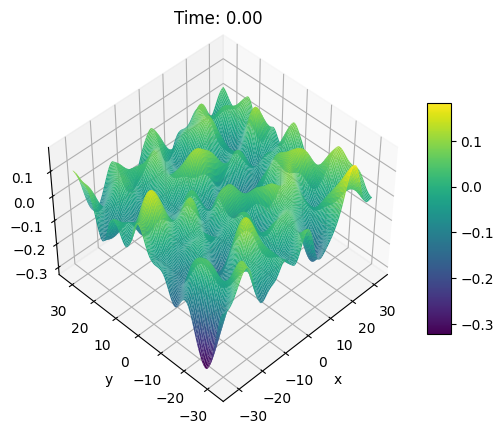

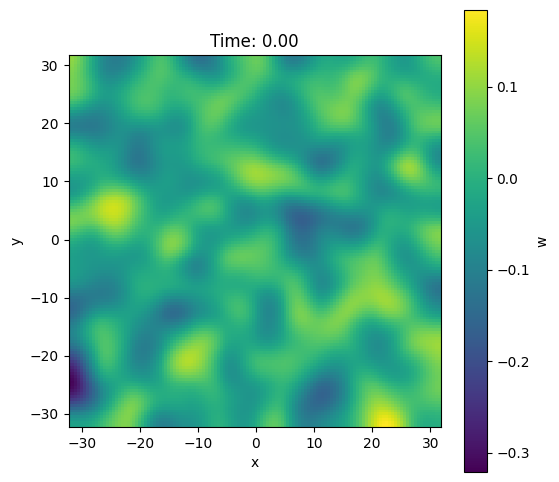

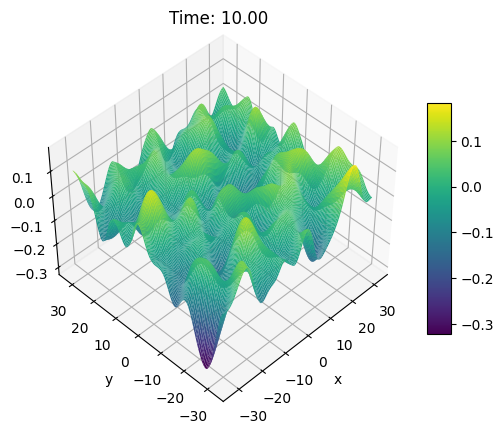

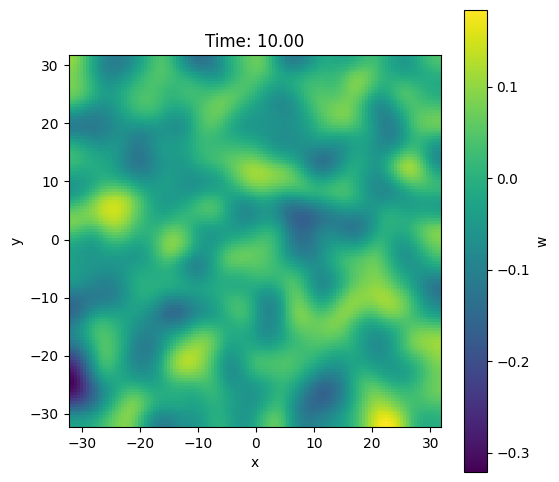

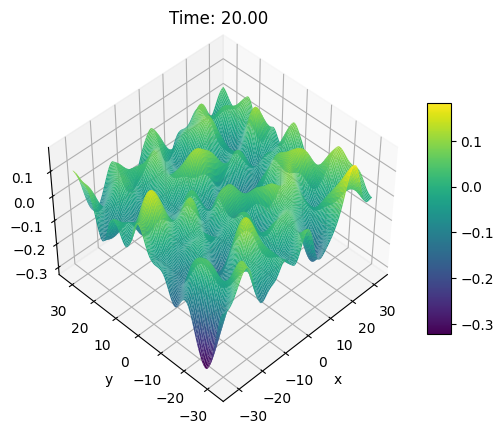

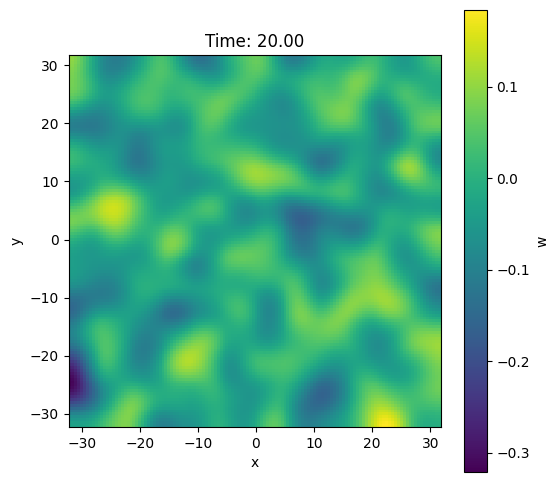

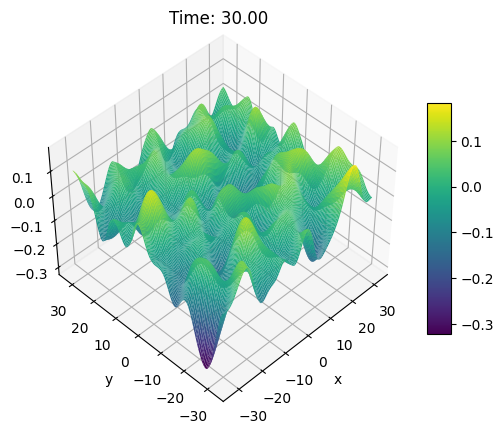

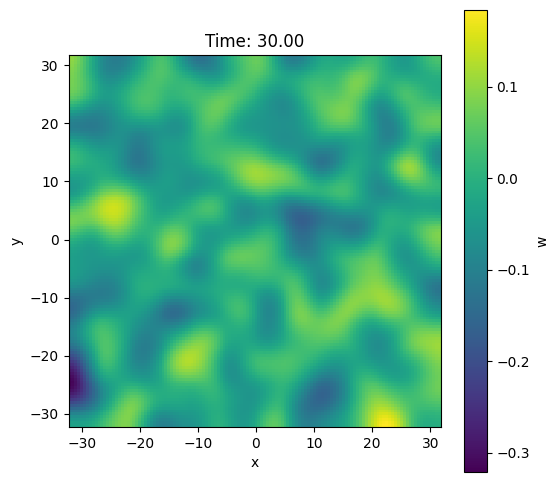

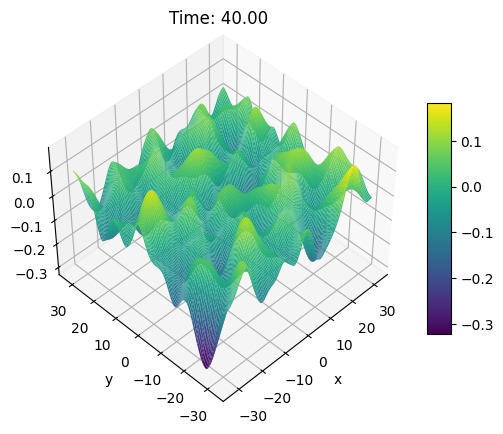

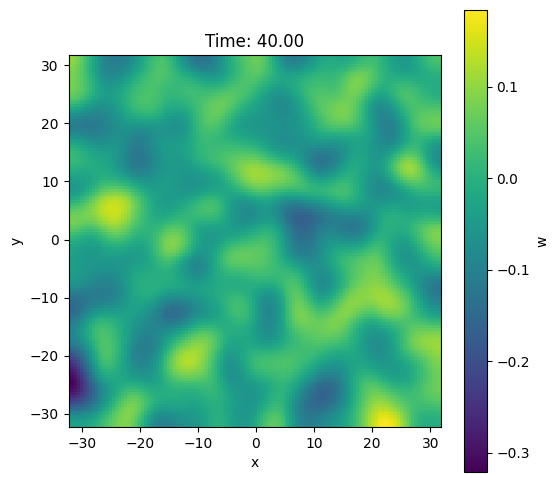

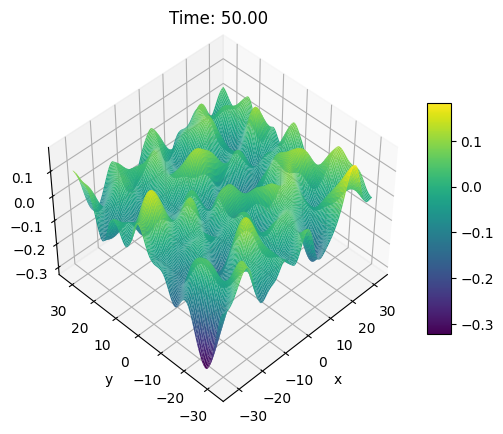

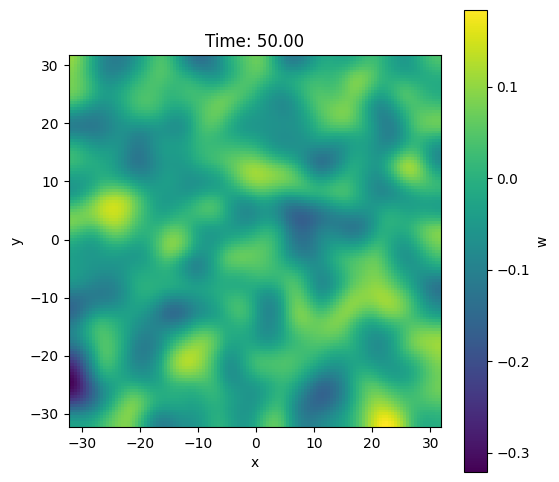

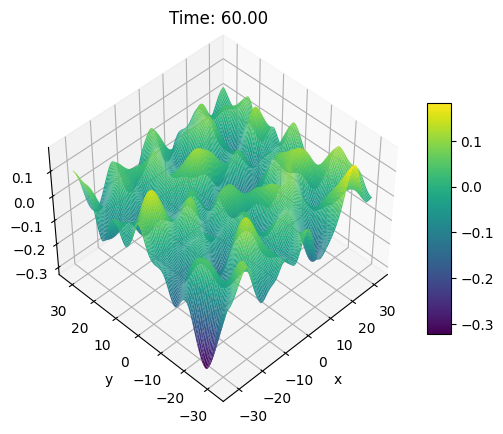

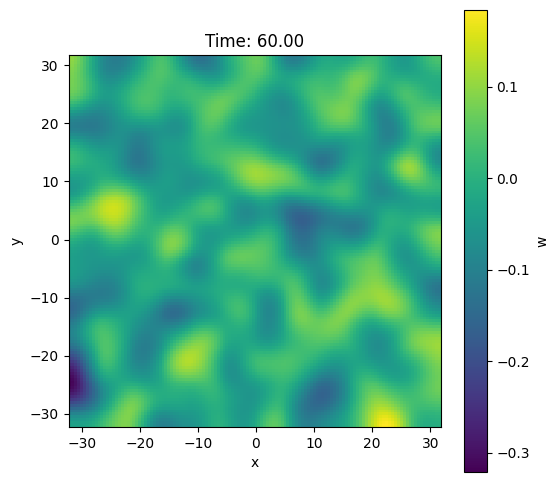

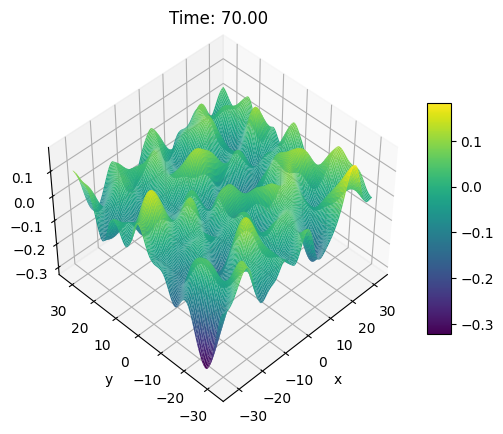

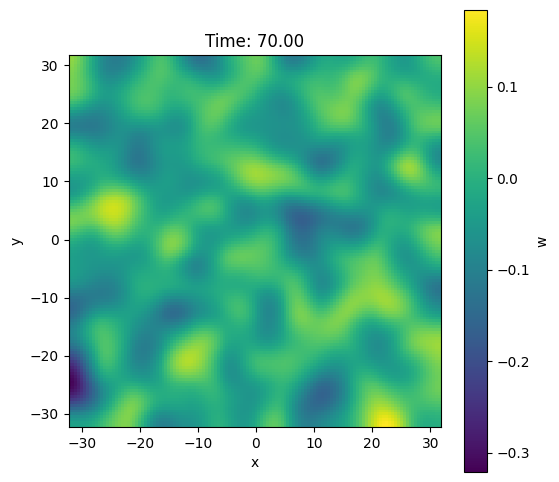

KeyboardInterrupt: 

In [ ]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=100, 
                                                                                                Nx = 128, Ny = 128, Lx = 64, Ly = 64)
# Initial conditions

# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
# w = np.random.randn(int(Nx/2), int(Ny/2)) * 0.1  # Initial perturbation for w
# w = np.random.uniform(0, 1, (int(Nx/4), int(Ny/4))) * 0.1
w = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)
u1 = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)             # Initial displacement in x direction
u2 = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)            # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)


for step in range(steps):

    w_tilde_new_non_linear, u1_tilde_new_non_linear, u2_tilde_new_non_linear = non_linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde, 
                                                                                                             KX, KY, non_linear_prefactor)

    w_tilde_new = w_tilde + w_tilde_new_non_linear
    u1_tilde_new = w_tilde + u1_tilde_new_non_linear
    u2_tilde_new = w_tilde + u2_tilde_new_non_linear
    
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new
    
    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 1000 == 0:

        w_values.append(w[10, 10])
        #print(w_tilde_new_non_linear/w_tilde_new_f_el)
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
    

# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 1000), w_values, marker='o')
# plt.title('Value of w at (0,0) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# plt.show()


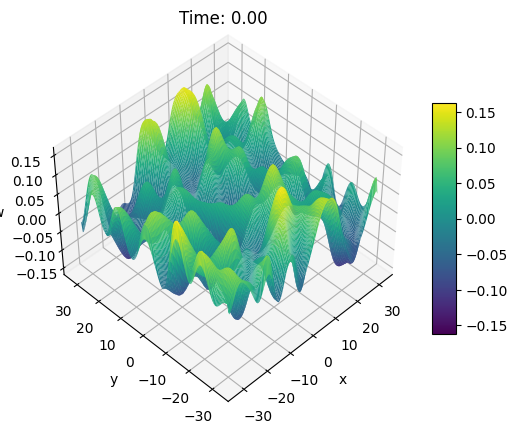

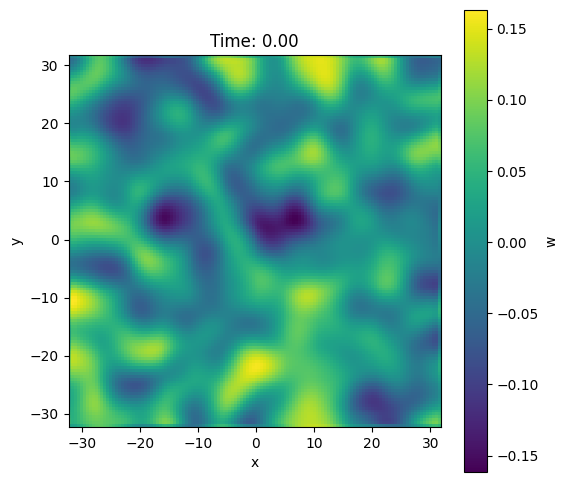

C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:173: RuntimeWarning: overflow encountered in multiply
  term1 = d2w_dx2 * (2 * du1_dx + 2 * dw_dx**2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:174: RuntimeWarning: overflow encountered in multiply
  term2 = dw_dx * (2 * d2u1_dx2 + 2 * d2w_dx2 * dw_dx + dw_dx**2 * d2w_dx2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:175: RuntimeWarning: overflow encountered in multiply
  term3 = 2 * d2w_dxdy * (du1_dy + du2_dx + 2 * dw_dx * dw_dy)
C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:176: RuntimeWarning: overflow encountered in multiply
  term4 = dw_dx * (d2u1_dy2 + d2u2_dxdy + 2 * d2w_dxdy * dw_dy + dw_dx * d2w_dy2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:177: RuntimeWarning: overflow encountered in multiply
  term5 = dw_dy * (d2u2_dx2 + d2u1_dxdy + 2 * d2w_dxdy * dw_dx + dw_dy * d2w_dx2)
C:\Users\Hp\AppData\Local\Temp\ipykernel_19152\1071873147.py:178: RuntimeW

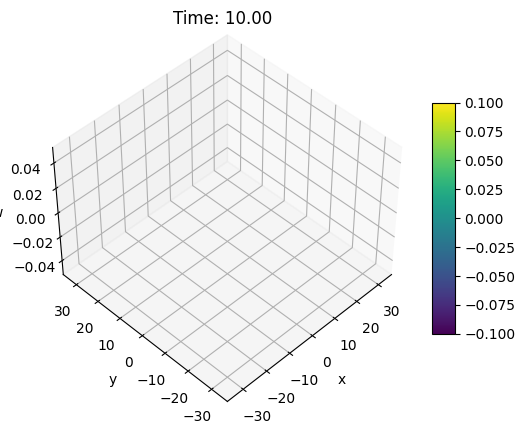

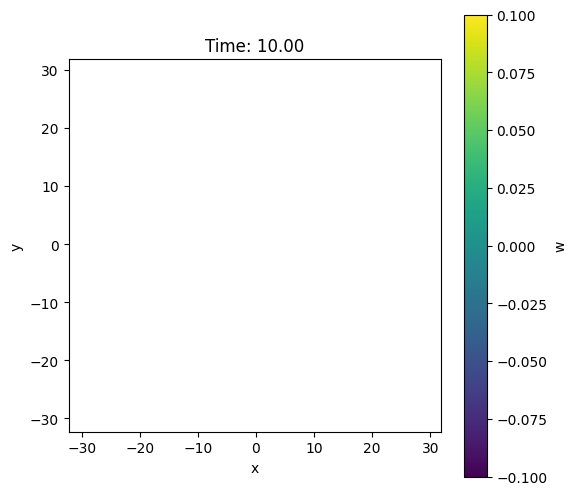

KeyboardInterrupt: 

In [ ]:
Nx, Ny, Lx, Ly, dx, dy, dt, total_time, steps, x, y, X, Y, kx, ky, KX, KY, K_squared, K, K_fourth, center_idx = initialize_grid(total_time=100, 
                                                                                                Nx = 128, Ny = 128, Lx = 64, Ly = 64)

# Initial conditions

# w = np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/16)
# w = np.exp((-X*X - Y*Y)) * 0.1
w = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)
# w = np.ones((Nx, Ny))
u1 = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)             # Initial displacement in x direction
u2 = generate_smooth_random_2d_array(size=(Nx, Ny), sigma=5.0)            # Initial displacement in y direction
w_values = []                       # List to store the value of w at (10,10) over time

# Fourier transforms of fields
w_tilde = fft_transform(w)
u1_tilde = fft_transform(u1)
u2_tilde = fft_transform(u2)

for step in range(steps):

    w_tilde_new_linear, u1_tilde_new_linear, u2_tilde_new_linear = linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_f_el, u1_tilde_new_f_el, u2_tilde_new_f_el = f_el_first_order_scheme(w_tilde, u1_tilde, u2_tilde)
    w_tilde_new_non_linear, u1_tilde_new_non_linear, u2_tilde_new_non_linear = non_linear_first_order_scheme(w_tilde, u1_tilde, u2_tilde,
                                                                                                              KX, KY, non_linear_prefactor)

    w_tilde_new = w_tilde_new_linear + w_tilde_new_f_el + w_tilde_new_non_linear
    u1_tilde_new = u1_tilde_new_linear + u1_tilde_new_f_el + u1_tilde_new_non_linear
    u2_tilde_new = u2_tilde_new_linear + u2_tilde_new_f_el + u2_tilde_new_non_linear
    
    w_tilde = w_tilde_new
    u1_tilde = u1_tilde_new
    u2_tilde = u2_tilde_new

    # Inverse Fourier transforms to get updated fields in real space
    w = ifft_transform(w_tilde_new)
    u1 = ifft_transform(u1_tilde_new)
    u2 = ifft_transform(u2_tilde_new)
    
    # Visualization (every 100 steps)
    if step % 1000 == 0:

        w_values.append(w[10, 10])
        #print(w_tilde_new_non_linear/w_tilde_new_f_el)
        plot_3d(X, Y, w, f'Time: {step * dt:.2f}')
        plot_2d(X, Y, w, f'Time: {step * dt:.2f}')
    

# plt.figure(figsize=(10, 6))
# plt.plot(range(0, steps, 1000), w_values, marker='o')
# plt.title('Value of w at (10,10) over time')
# plt.xlabel('Time step')
# plt.ylabel('w(0,0)')
# plt.grid(True)
# plt.show()
